In [1]:
# Importing important packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# Importing Data
directory = os.getcwd()

beaks_1975 = pd.read_csv(r'%s\datasets\finch_beaks_1975.csv' % directory)
beaks_1975['year'] = 1975

beaks_2012 = pd.read_csv(r'%s\datasets\finch_beaks_2012.csv' % directory)
beaks_2012['year'] = 2012

beaks_1975.columns = beaks_2012.columns

In [3]:
### Useful functions

def ecdf(data):
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for _ in range(size)])

def pearson_r(data_1, data_2):
    return np.corrcoef(data_1, data_2)[0,1]

### Study: 40 years of evolution. Darwin's finches on Daphne Major Island

This notebook is based on the chapter <strong><em>Putting it all together: a case study</em></strong> from <strong><em>Statistical Thinking in Python (Part 2)</em></strong> course into Datacamp's Data Scientist Proffessional Certification track, follow <a href="https://www.datacamp.com/tracks/data-scientist-with-python">this link</a> for further information.

This project is based on the study made by Peter and Rosemary Grant of Princeton University whom have been spending several months of the year on the volcanic island of Daphne Major in the Galápagos. The study is documented in the book <em>"40 Years of Evolution: Darwin's Finches on Daphne Major Island"</em> and all the data is located in <a href="https://datadryad.org/stash/dataset/doi:10.5061/dryad.g6g3h">this online repository</a>

The goal of this notebook is to analyze different aspects of the beak geometry, including how it varies over time, from species to species, and from parents to offspring. To achieve this we will investigate how the beak depth of Geospiza scandens has changed over time by applying some exploratory analysis of the measurements of these species from 1975 and 2012. Then perform a parameter estimation, with confidence intervals, of mean beak depth for those respective years. Finally, do a hypothesis test to investigate if the mean beak depth has changed from 1975 to 2012.

### 1 - EDA of beak depths of Darwin's finches

Beginning with the study of how the beak depth (the distance, top to bottom, of a closed beak) of the finch species Geospiza scandens has changed over time. The Grants have noticed some changes of beak geometry depending on the types of seeds available on the island, and they also noticed that there was some interbreeding with another major species on Daphne Major, Geospiza fortis. These effects can lead to changes in the species over time.

Next few problems, we will look at the beak depth of G. scandens on Daphne Major in 1975 and in 2012. To start with, let's plot all of the beak depth measurements in 1975 and 2012 in a bee swarm plot.

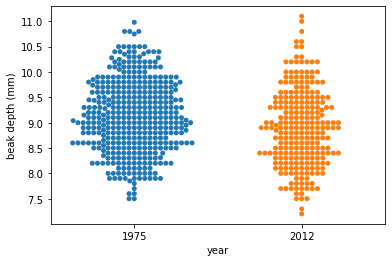

In [4]:
# Unifying 1975 and 2012 data
df = pd.concat([beaks_1975, beaks_2012])[['bdepth', 'year']]

# Create bee swarm plot
_ = sns.swarmplot('year', 'bdepth', data=df)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
plt.show()

`It is kind of hard to see if there is a clear difference between the 1975 and 2012 data set. Eyeballing it, it appears as though the mean of the 2012 data set might be slightly higher, and it might have a bigger variance`

### 2 - ECDFs of beak depths

While bee swarm plots are useful, we found that ECDFs are often even better when doing EDA.

The beak depths for the respective years has been stored in the NumPy arrays bd_1975 and bd_2012.

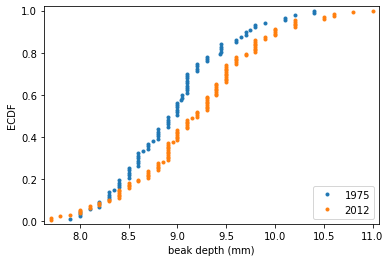

In [5]:
bd_1975 = np.array([ 8.4 ,  8.8 ,  8.4 ,  8.  ,  7.9 ,  8.9 ,  8.6 ,  8.5 ,  8.9 ,
        9.1 ,  8.6 ,  9.8 ,  8.2 ,  9.  ,  9.7 ,  8.6 ,  8.2 ,  9.  ,
        8.4 ,  8.6 ,  8.9 ,  9.1 ,  8.3 ,  8.7 ,  9.6 ,  8.5 ,  9.1 ,
        9.  ,  9.2 ,  9.9 ,  8.6 ,  9.2 ,  8.4 ,  8.9 ,  8.5 , 10.4 ,
        9.6 ,  9.1 ,  9.3 ,  9.3 ,  8.8 ,  8.3 ,  8.8 ,  9.1 , 10.1 ,
        8.9 ,  9.2 ,  8.5 , 10.2 , 10.1 ,  9.2 ,  9.7 ,  9.1 ,  8.5 ,
        8.2 ,  9.  ,  9.3 ,  8.  ,  9.1 ,  8.1 ,  8.3 ,  8.7 ,  8.8 ,
        8.6 ,  8.7 ,  8.  ,  8.8 ,  9.  ,  9.1 ,  9.74,  9.1 ,  9.8 ,
       10.4 ,  8.3 ,  9.44,  9.04,  9.  ,  9.05,  9.65,  9.45,  8.65,
        9.45,  9.45,  9.05,  8.75,  9.45,  8.35])

bd_2012 = np.array([ 9.4 ,  8.9 ,  9.5 , 11.  ,  8.7 ,  8.4 ,  9.1 ,  8.7 , 10.2 ,
        9.6 ,  8.85,  8.8 ,  9.5 ,  9.2 ,  9.  ,  9.8 ,  9.3 ,  9.  ,
       10.2 ,  7.7 ,  9.  ,  9.5 ,  9.4 ,  8.  ,  8.9 ,  9.4 ,  9.5 ,
        8.  , 10.  ,  8.95,  8.2 ,  8.8 ,  9.2 ,  9.4 ,  9.5 ,  8.1 ,
        9.5 ,  8.4 ,  9.3 ,  9.3 ,  9.6 ,  9.2 , 10.  ,  8.9 , 10.5 ,
        8.9 ,  8.6 ,  8.8 ,  9.15,  9.5 ,  9.1 , 10.2 ,  8.4 , 10.  ,
       10.2 ,  9.3 , 10.8 ,  8.3 ,  7.8 ,  9.8 ,  7.9 ,  8.9 ,  7.7 ,
        8.9 ,  9.4 ,  9.4 ,  8.5 ,  8.5 ,  9.6 , 10.2 ,  8.8 ,  9.5 ,
        9.3 ,  9.  ,  9.2 ,  8.7 ,  9.  ,  9.1 ,  8.7 ,  9.4 ,  9.8 ,
        8.6 , 10.6 ,  9.  ,  9.5 ,  8.1 ,  9.3 ,  9.6 ,  8.5 ,  8.2 ,
        8.  ,  9.5 ,  9.7 ,  9.9 ,  9.1 ,  9.5 ,  9.8 ,  8.4 ,  8.3 ,
        9.6 ,  9.4 , 10.  ,  8.9 ,  9.1 ,  9.8 ,  9.3 ,  9.9 ,  8.9 ,
        8.5 , 10.6 ,  9.3 ,  8.9 ,  8.9 ,  9.7 ,  9.8 , 10.5 ,  8.4 ,
       10.  ,  9.  ,  8.7 ,  8.8 ,  8.4 ,  9.3 ,  9.8 ,  8.9 ,  9.8 ,
        9.1 ])

# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

`The differences are much clearer in the ECDF. The mean is larger in the 2012 data, and the variance does appear larger as well.`

### 3 - Parameter estimates of beak depths

Now we estimate the difference of the mean beak depth of the G. scandens samples from 1975 and 2012 and report a 95% confidence interval.

In [6]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, size=10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.06048982 0.39464399] mm


### 4 - Hypothesis test: Are beaks deeper in 2012?

The plot of the ECDF and determination of the confidence interval make it pretty clear that the beaks of G. scandens on Daphne Major have gotten deeper. But is it possible that this effect is just due to random chance? In other words, what is the probability that we would get the observed difference in mean beak depth if the means were the same?

The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The hypothesis is that the means are equal.

In [7]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0039


`We get a p-value of 0.0034, which suggests that there is a statistically significant difference. But it's still very important to know how different they are! Changing by 0.2 mm in 37 years is substantial by evolutionary standards. If it kept changing at that rate, the beak depth would double in only 400 years.`

### 5 - EDA of beak length and depth

The beak length data are stored as bl_1975 and bl_2012, again with units of millimeters (mm). You still have the beak depth data stored in bd_1975 and bd_2012

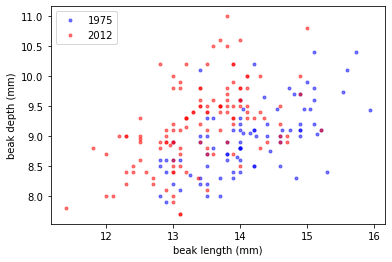

In [8]:
bl_1975 = np.array([13.9 , 14.  , 12.9 , 13.5 , 12.9 , 14.6 , 13.  , 14.2 , 14.  ,
       14.2 , 13.1 , 15.1 , 13.5 , 14.4 , 14.9 , 12.9 , 13.  , 14.9 ,
       14.  , 13.8 , 13.  , 14.75, 13.7 , 13.8 , 14.  , 14.6 , 15.2 ,
       13.5 , 15.1 , 15.  , 12.8 , 14.9 , 15.3 , 13.4 , 14.2 , 15.1 ,
       15.1 , 14.  , 13.6 , 14.  , 14.  , 13.9 , 14.  , 14.9 , 15.6 ,
       13.8 , 14.4 , 12.8 , 14.2 , 13.4 , 14.  , 14.8 , 14.2 , 13.5 ,
       13.4 , 14.6 , 13.5 , 13.7 , 13.9 , 13.1 , 13.4 , 13.8 , 13.6 ,
       14.  , 13.5 , 12.8 , 14.  , 13.4 , 14.9 , 15.54, 14.63, 14.73,
       15.73, 14.83, 15.94, 15.14, 14.23, 14.15, 14.35, 14.95, 13.95,
       14.05, 14.55, 14.05, 14.45, 15.05, 13.25])

bl_2012 = np.array([14.3 , 12.5 , 13.7 , 13.8 , 12.  , 13.  , 13.  , 13.6 , 12.8 ,
       13.6 , 12.95, 13.1 , 13.4 , 13.9 , 12.3 , 14.  , 12.5 , 12.3 ,
       13.9 , 13.1 , 12.5 , 13.9 , 13.7 , 12.  , 14.4 , 13.5 , 13.8 ,
       13.  , 14.9 , 12.5 , 12.3 , 12.8 , 13.4 , 13.8 , 13.5 , 13.5 ,
       13.4 , 12.3 , 14.35, 13.2 , 13.8 , 14.6 , 14.3 , 13.8 , 13.6 ,
       12.9 , 13.  , 13.5 , 13.2 , 13.7 , 13.1 , 13.2 , 12.6 , 13.  ,
       13.9 , 13.2 , 15.  , 13.37, 11.4 , 13.8 , 13.  , 13.  , 13.1 ,
       12.8 , 13.3 , 13.5 , 12.4 , 13.1 , 14.  , 13.5 , 11.8 , 13.7 ,
       13.2 , 12.2 , 13.  , 13.1 , 14.7 , 13.7 , 13.5 , 13.3 , 14.1 ,
       12.5 , 13.7 , 14.6 , 14.1 , 12.9 , 13.9 , 13.4 , 13.  , 12.7 ,
       12.1 , 14.  , 14.9 , 13.9 , 12.9 , 14.6 , 14.  , 13.  , 12.7 ,
       14.  , 14.1 , 14.1 , 13.  , 13.5 , 13.4 , 13.9 , 13.1 , 12.9 ,
       14.  , 14.  , 14.1 , 14.7 , 13.4 , 13.8 , 13.4 , 13.8 , 12.4 ,
       14.1 , 12.9 , 13.9 , 14.3 , 13.2 , 14.2 , 13.  , 14.6 , 13.1 ,
       15.2 ])

# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
            linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')


`In looking at the plot, we see that beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; they became shorter and deeper.`

### 6 - Linear regressions

Performing a linear regression for both the 1975 and 2012 data.

In [9]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize samples
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Take samples
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [10]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, size=1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, size=1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(bs_intercept_reps_2012, [2.5, 97.5])


# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.33044834 0.58743289]
1975: intercept = 2.3908752365842267 conf int = [0.66860213 4.25664563]
2012: slope = 0.462630358835313 conf int = [0.3378721  0.60523489]
2012: intercept = 2.9772474982360198 conf int = [1.10032189 4.65061571]


### 7 - Displaying the linear regression results

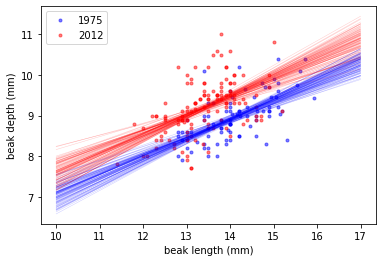

In [11]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17], )

# Plot the bootstrap lines
for i in range(100):
    plt.plot(x,  bs_slope_reps_1975[i]*x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i]*x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

### 8 - Beak length to depth ratio

The linear regressions showed interesting information about the beak geometry. The slope was the same in 1975 and 2012, suggesting that for every millimeter gained in beak length, the birds gained about half a millimeter in depth in both years. However, if we are interested in the shape of the beak, we want to compare the ratio of beak length to beak depth. Let's make that comparison.

In [12]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975/bd_1975
ratio_2012 = bl_2012/bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, size=10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)


1975: mean ratio = 1.5788823771858533 conf int = [1.55611908 1.60067326]
2012: mean ratio = 1.4658342276847767 conf int = [1.44384135 1.48810269]


### 9 - EDA of heritability

The array bd_parent_scandens contains the average beak depth (in mm) of two parents of the species G. scandens. The array bd_offspring_scandens contains the average beak depth of the offspring of the respective parents. The arrays bd_parent_fortis and bd_offspring_fortis contain the same information about measurements from G. fortis birds.

In [13]:
# Importing data
bd_parent_fortis = np.array([10.1  ,  9.55 ,  9.4  , 10.25 , 10.125,  9.7  ,  9.05 ,  7.4  ,
        9.   ,  8.65 ,  9.625,  9.9  ,  9.55 ,  9.05 ,  8.35 , 10.1  ,
       10.1  ,  9.9  , 10.225, 10.   , 10.55 , 10.45 ,  9.2  , 10.2  ,
        8.95 , 10.05 , 10.2  ,  9.5  ,  9.925,  9.95 , 10.05 ,  8.75 ,
        9.2  , 10.15 ,  9.8  , 10.7  , 10.5  ,  9.55 , 10.55 , 10.475,
        8.65 , 10.7  ,  9.1  ,  9.4  , 10.3  ,  9.65 ,  9.5  ,  9.7  ,
       10.525,  9.95 , 10.1  ,  9.75 , 10.05 ,  9.9  , 10.   ,  9.1  ,
        9.45 ,  9.25 ,  9.5  , 10.   , 10.525,  9.9  , 10.4  ,  8.95 ,
        9.4  , 10.95 , 10.75 , 10.1  ,  8.05 ,  9.1  ,  9.55 ,  9.05 ,
       10.2  , 10.   , 10.55 , 10.75 ,  8.175,  9.7  ,  8.8  , 10.75 ,
        9.3  ,  9.7  ,  9.6  ,  9.75 ,  9.6  , 10.45 , 11.   , 10.85 ,
       10.15 , 10.35 , 10.4  ,  9.95 ,  9.1  , 10.1  ,  9.85 ,  9.625,
        9.475,  9.   ,  9.25 ,  9.1  ,  9.25 ,  9.2  ,  9.95 ,  8.65 ,
        9.8  ,  9.4  ,  9.   ,  8.55 ,  8.75 ,  9.65 ,  8.95 ,  9.15 ,
        9.85 , 10.225,  9.825, 10.   ,  9.425, 10.4  ,  9.875,  8.95 ,
        8.9  ,  9.35 , 10.425, 10.   , 10.175,  9.875,  9.875,  9.15 ,
        9.45 ,  9.025,  9.7  ,  9.7  , 10.05 , 10.3  ,  9.6  , 10.   ,
        9.8  , 10.05 ,  8.75 , 10.55 ,  9.7  , 10.   ,  9.85 ,  9.8  ,
        9.175,  9.65 ,  9.55 ,  9.9  , 11.55 , 11.3  , 10.4  , 10.8  ,
        9.8  , 10.45 , 10.   , 10.75 ,  9.35 , 10.75 ,  9.175,  9.65 ,
        8.8  , 10.55 , 10.675,  9.95 ,  9.55 ,  8.825,  9.7  ,  9.85 ,
        9.8  ,  9.55 ,  9.275, 10.325,  9.15 ,  9.35 ,  9.15 ,  9.65 ,
       10.575,  9.975,  9.55 ,  9.2  ,  9.925,  9.2  ,  9.3  ,  8.775,
        9.325,  9.175,  9.325,  8.975,  9.7  ,  9.5  , 10.225, 10.025,
        8.2  ,  8.2  ,  9.55 ,  9.05 ,  9.6  ,  9.6  , 10.15 ,  9.875,
       10.485, 11.485, 10.985,  9.7  ,  9.65 ,  9.35 , 10.05 , 10.1  ,
        9.9  ,  8.95 ,  9.3  ,  9.95 ,  9.45 ,  9.5  ,  8.45 ,  8.8  ,
        8.525,  9.375, 10.2  ,  7.625,  8.375,  9.25 ,  9.4  , 10.55 ,
        8.9  ,  8.8  ,  9.   ,  8.575,  8.575,  9.6  ,  9.375,  9.6  ,
        9.95 ,  9.6  , 10.2  ,  9.85 ,  9.625,  9.025, 10.375, 10.25 ,
        9.3  ,  9.5  ,  9.55 ,  8.55 ,  9.05 ,  9.9  ,  9.8  ,  9.75 ,
       10.25 ,  9.1  ,  9.65 , 10.3  ,  8.9  ,  9.95 ,  9.5  ,  9.775,
        9.425,  7.75 ,  7.55 ,  9.1  ,  9.6  ,  9.575,  8.95 ,  9.65 ,
        9.65 ,  9.65 ,  9.525,  9.85 ,  9.05 ,  9.3  ,  8.9  ,  9.45 ,
       10.   ,  9.85 ,  9.25 , 10.1  ,  9.125,  9.65 ,  9.1  ,  8.05 ,
        7.4  ,  8.85 ,  9.075,  9.   ,  9.7  ,  8.7  ,  9.45 ,  9.7  ,
        8.35 ,  8.85 ,  9.7  ,  9.45 , 10.3  , 10.   , 10.45 ,  9.45 ,
        8.5  ,  8.3  , 10.   ,  9.225,  9.75 ,  9.15 ,  9.55 ,  9.   ,
        9.275,  9.35 ,  8.95 ,  9.875,  8.45 ,  8.6  ,  9.7  ,  8.55 ,
        9.05 ,  9.6  ,  8.65 ,  9.2  ,  8.95 ,  9.6  ,  9.15 ,  9.4  ,
        8.95 ,  9.95 , 10.55 ,  9.7  ,  8.85 ,  8.8  , 10.   ,  9.05 ,
        8.2  ,  8.1  ,  7.25 ,  8.3  ,  9.15 ,  8.6  ,  9.5  ,  8.05 ,
        9.425,  9.3  ,  9.8  ,  9.3  ,  9.85 ,  9.5  ,  8.65 ,  9.825,
        9.   , 10.45 ,  9.1  ,  9.55 ,  9.05 , 10.   ,  9.35 ,  8.375,
        8.3  ,  8.8  , 10.1  ,  9.5  ,  9.75 , 10.1  ,  9.575,  9.425,
        9.65 ,  8.725,  9.025,  8.5  ,  8.95 ,  9.3  ,  8.85 ,  8.95 ,
        9.8  ,  9.5  ,  8.65 ,  9.1  ,  9.4  ,  8.475,  9.35 ,  7.95 ,
        9.35 ,  8.575,  9.05 ,  8.175,  9.85 ,  7.85 ,  9.85 , 10.1  ,
        9.35 ,  8.85 ,  8.75 ,  9.625,  9.25 ,  9.55 , 10.325,  8.55 ,
        9.675,  9.15 ,  9.   ,  9.65 ,  8.6  ,  8.8  ,  9.   ,  9.95 ,
        8.4  ,  9.35 , 10.3  ,  9.05 ,  9.975,  9.975,  8.65 ,  8.725,
        8.2  ,  7.85 ,  8.775,  8.5  ,  9.4  ])

bd_offspring_fortis = np.array([10.7 ,  9.78,  9.48,  9.6 , 10.27,  9.5 ,  9.  ,  7.46,  7.65,
        8.63,  9.81,  9.4 ,  9.48,  8.75,  7.6 , 10.  , 10.09,  9.74,
        9.64,  8.49, 10.15, 10.28,  9.2 , 10.01,  9.03,  9.94, 10.5 ,
        9.7 , 10.02, 10.04,  9.43,  8.1 ,  9.5 ,  9.9 ,  9.48, 10.18,
       10.16,  9.08, 10.39,  9.9 ,  8.4 , 10.6 ,  8.75,  9.46,  9.6 ,
        9.6 ,  9.95, 10.05, 10.16, 10.1 ,  9.83,  9.46,  9.7 ,  9.82,
       10.34,  8.02,  9.65,  9.87,  9.  , 11.14,  9.25,  8.14, 10.23,
        8.7 ,  9.8 , 10.54, 11.19,  9.85,  8.1 ,  9.3 ,  9.34,  9.19,
        9.52,  9.36,  8.8 ,  8.6 ,  8.  ,  8.5 ,  8.3 , 10.38,  8.54,
        8.94, 10.  ,  9.76,  9.45,  9.89, 10.9 ,  9.91,  9.39,  9.86,
        9.74,  9.9 ,  9.09,  9.69, 10.24,  8.9 ,  9.67,  8.93,  9.3 ,
        8.67,  9.15,  9.23,  9.59,  9.03,  9.58,  8.97,  8.57,  8.47,
        8.71,  9.21,  9.13,  8.5 ,  9.58,  9.21,  9.6 ,  9.32,  8.7 ,
       10.46,  9.29,  9.24,  9.45,  9.35, 10.19,  9.91,  9.18,  9.89,
        9.6 , 10.3 ,  9.45,  8.79,  9.2 ,  8.8 ,  9.69, 10.61,  9.6 ,
        9.9 ,  9.26, 10.2 ,  8.79,  9.28,  8.83,  9.76, 10.2 ,  9.43,
        9.4 ,  9.9 ,  9.5 ,  8.95,  9.98,  9.72,  9.86, 11.1 ,  9.14,
       10.49,  9.75, 10.35,  9.73,  9.83,  8.69,  9.58,  8.42,  9.25,
       10.12,  9.31,  9.99,  8.59,  8.74,  8.79,  9.6 ,  9.52,  8.93,
       10.23,  9.35,  9.35,  9.09,  9.04,  9.75, 10.5 ,  9.09,  9.05,
        9.54,  9.3 ,  9.06,  8.7 ,  9.32,  8.4 ,  8.67,  8.6 ,  9.53,
        9.77,  9.65,  9.43,  8.35,  8.26,  9.5 ,  8.6 ,  9.57,  9.14,
       10.79,  8.91,  9.93, 10.7 ,  9.3 ,  9.93,  9.51,  9.44, 10.05,
       10.13,  9.24,  8.21,  8.9 ,  9.34,  8.77,  9.4 ,  8.82,  8.83,
        8.6 ,  9.5 , 10.2 ,  8.09,  9.07,  9.29,  9.1 , 10.19,  9.25,
        8.98,  9.02,  8.6 ,  8.25,  8.7 ,  9.9 ,  9.65,  9.45,  9.38,
       10.4 ,  9.96,  9.46,  8.26, 10.05,  8.92,  9.5 ,  9.43,  8.97,
        8.44,  8.92, 10.3 ,  8.4 ,  9.37,  9.91, 10.  ,  9.21,  9.95,
        8.84,  9.82,  9.5 , 10.29,  8.4 ,  8.31,  9.29,  8.86,  9.4 ,
        9.62,  8.62,  8.3 ,  9.8 ,  8.48,  9.61,  9.5 ,  9.37,  8.74,
        9.31,  9.5 ,  9.49,  9.74,  9.2 ,  9.24,  9.7 ,  9.64,  9.2 ,
        7.5 ,  7.5 ,  8.7 ,  8.31,  9.  ,  9.74,  9.31, 10.5 ,  9.3 ,
        8.12,  9.34,  9.72,  9.  ,  9.65,  9.9 , 10.  , 10.1 ,  8.  ,
        9.07,  9.75,  9.33,  8.11,  9.36,  9.74,  9.9 ,  9.23,  9.7 ,
        8.2 ,  9.35,  9.49,  9.34,  8.87,  9.03,  9.07,  9.43,  8.2 ,
        9.19,  9.  ,  9.2 ,  9.06,  9.81,  8.89,  9.4 , 10.45,  9.64,
        9.03,  8.71,  9.91,  8.33,  8.2 ,  7.83,  7.14,  8.91,  9.18,
        8.8 ,  9.9 ,  7.73,  9.25,  8.7 ,  9.5 ,  9.3 ,  9.05, 10.18,
        8.85,  9.24,  9.15,  9.98,  8.77,  9.8 ,  8.65, 10.  ,  8.81,
        8.01,  7.9 ,  9.41, 10.18,  9.55,  9.08,  8.4 ,  9.75,  8.9 ,
        9.07,  9.35,  8.9 ,  8.19,  8.65,  9.19,  8.9 ,  9.28, 10.58,
        9.  ,  9.4 ,  8.91,  9.93, 10.  ,  9.37,  7.4 ,  9.  ,  8.8 ,
        9.18,  8.3 , 10.08,  7.9 ,  9.96, 10.4 ,  9.65,  8.8 ,  8.65,
        9.7 ,  9.23,  9.43,  9.93,  8.47,  9.55,  9.28,  8.85,  8.9 ,
        8.75,  8.63,  9.  ,  9.43,  8.28,  9.23, 10.4 ,  9.  ,  9.8 ,
        9.77,  8.97,  8.37,  7.7 ,  7.9 ,  9.5 ,  8.2 ,  8.8 ])

bd_offspring_scandens = np.array([ 8.419 ,  9.2468,  8.1532,  8.0089,  8.2215,  8.3734,  8.5025,
        8.6392,  8.7684,  8.8139,  8.7911,  8.9051,  8.9203,  8.8747,
        8.943 ,  9.0038,  8.981 ,  9.0949,  9.2696,  9.1633,  9.1785,
        9.1937,  9.2772,  9.0722,  8.9658,  8.9658,  8.5025,  8.4949,
        8.4949,  8.5633,  8.6013,  8.6468,  8.1532,  8.3734,  8.662 ,
        8.6924,  8.7456,  8.8367,  8.8595,  8.9658,  8.9582,  8.8671,
        8.8671,  8.943 ,  9.0646,  9.1405,  9.2089,  9.2848,  9.3759,
        9.4899,  9.4519,  8.1228,  8.2595,  8.3127,  8.4949,  8.6013,
        8.4646,  8.5329,  8.7532,  8.8823,  9.0342,  8.6392,  8.6772,
        8.6316,  8.7532,  8.8291,  8.8975,  8.9734,  9.0494,  9.1253,
        9.1253,  9.1253,  9.1785,  9.2848,  9.4595,  9.3608,  9.2089,
        9.2544,  9.3684,  9.3684,  9.2316,  9.1709,  9.2316,  9.0342,
        8.8899,  8.8291,  8.981 ,  8.8975, 10.4089, 10.1886,  9.7633,
        9.7329,  9.6114,  9.5051,  9.5127,  9.3684,  9.6266,  9.5354,
       10.0215, 10.0215,  9.6266,  9.6038,  9.4063,  9.2316,  9.338 ,
        9.262 ,  9.262 ,  9.4063,  9.4367,  9.0342,  8.943 ,  8.9203,
        8.7835,  8.7835,  9.057 ,  8.9354,  8.8975,  8.8139,  8.8671,
        9.0873,  9.2848,  9.2392,  9.2924,  9.4063,  9.3152,  9.4899,
        9.5962,  9.6873,  9.5203,  9.6646])

bd_parent_scandens = np.array([ 8.3318,  8.4035,  8.5317,  8.7202,  8.7089,  8.7541,  8.773 ,
        8.8107,  8.7919,  8.8069,  8.6523,  8.6146,  8.6938,  8.7127,
        8.7466,  8.7504,  8.7805,  8.7428,  8.7164,  8.8032,  8.8258,
        8.856 ,  8.9012,  8.9125,  8.8635,  8.8258,  8.8522,  8.8974,
        8.9427,  8.9879,  8.9615,  8.9238,  8.9351,  9.0143,  9.0558,
        9.0596,  8.9917,  8.905 ,  8.9314,  8.9465,  8.9879,  8.9804,
        9.0219,  9.052 ,  9.0407,  9.0407,  8.9955,  8.9992,  8.9992,
        9.0747,  9.0747,  9.5385,  9.4781,  9.4517,  9.3537,  9.2707,
        9.1199,  9.1689,  9.1425,  9.135 ,  9.1011,  9.1727,  9.2217,
        9.2255,  9.2821,  9.3235,  9.3198,  9.3198,  9.3198,  9.3273,
        9.3725,  9.3989,  9.4253,  9.4593,  9.4442,  9.4291,  9.2632,
        9.2293,  9.1878,  9.1425,  9.1275,  9.1802,  9.1765,  9.2481,
        9.2481,  9.1991,  9.1689,  9.1765,  9.2406,  9.3198,  9.3235,
        9.1991,  9.2971,  9.2443,  9.316 ,  9.2934,  9.3914,  9.3989,
        9.5121,  9.6176,  9.5535,  9.4668,  9.3725,  9.3348,  9.3763,
        9.3839,  9.4216,  9.4065,  9.3348,  9.4442,  9.4367,  9.5083,
        9.448 ,  9.4781,  9.595 ,  9.6101,  9.5686,  9.6365,  9.7119,
        9.8213,  9.825 ,  9.7609,  9.6516,  9.5988,  9.546 ,  9.6516,
        9.7572,  9.8854, 10.0023,  9.3914])

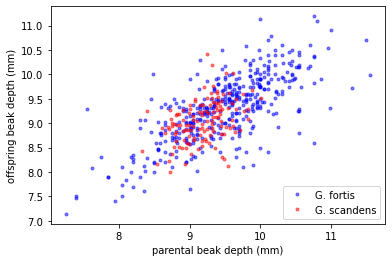

In [14]:
# Make scatter plots
_ = plt.plot(bd_parent_fortis, bd_offspring_fortis,
             marker='.', linestyle='none', color='blue', alpha=0.5)
_ = plt.plot(bd_parent_scandens, bd_offspring_scandens,
             marker='.', linestyle='none', color='red', alpha=0.5)

# Label axes
_ = plt.xlabel('parental beak depth (mm)')
_ = plt.ylabel('offspring beak depth (mm)')

# Add legend
_ = plt.legend(('G. fortis', 'G. scandens'), loc='lower right')

# Show plot
plt.show()


`It appears as though there is a stronger correlation in G. fortis than in G. scandens. This suggests that beak depth is more strongly inherited in G. fortis.`

### 10 - Correlation of offspring and parental data

In an effort to quantify the correlation between offspring and parent beak depths, we would like to compute statistics, such as the Pearson correlation coefficient, between parents and offspring. To get confidence intervals on this, we need to do a pairs bootstrap.

In [15]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

`The Pearson correlation coefficient seems like a useful measure of how strongly the beak depth of parents are inherited by their offspring.`

In [16]:
# Compute the Pearson correlation coefficients
r_scandens = pearson_r(bd_parent_scandens, bd_offspring_scandens)
r_fortis = pearson_r(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of Pearson r
bs_replicates_scandens = draw_bs_pairs(bd_parent_scandens, bd_offspring_scandens, pearson_r, size=1000)

bs_replicates_fortis = draw_bs_pairs(bd_parent_fortis, bd_offspring_fortis, pearson_r, size=1000)

# Compute 95% confidence intervals
conf_int_scandens = np.percentile(bs_replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(bs_replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', r_scandens, conf_int_scandens)
print('G. fortis:', r_fortis, conf_int_fortis)


G. scandens: 0.4117063629401258 [0.26813306 0.54321018]
G. fortis: 0.7283412395518486 [0.67026013 0.77917635]


`It is clear from the confidence intervals that beak depth of the offspring of G. fortis parents is more strongly correlated with their offspring than their G. scandens counterparts.`

### 11 - Measuring heritability

Remember that the Pearson correlation coefficient is the ratio of the covariance to the geometric mean of the variances of the two data sets. This is a measure of the correlation between parents and offspring, but might not be the best estimate of heritability. If we stop and think, it makes more sense to define heritability as the ratio of the covariance between parent and offspring to the variance of the parents alone. 

In [17]:
def heritability(parents, offspring):
    """Compute the heritability from parent and offspring samples."""
    covariance_matrix = np.cov(parents, offspring)
    return covariance_matrix[0,1] / covariance_matrix[0,0]

# Compute the heritability
heritability_scandens = heritability(bd_parent_scandens, bd_offspring_scandens)
heritability_fortis = heritability(bd_parent_fortis, bd_offspring_fortis)

# Acquire 1000 bootstrap replicates of heritability
replicates_scandens = draw_bs_pairs(
        bd_parent_scandens, bd_offspring_scandens, heritability, size=1000)
        
replicates_fortis = draw_bs_pairs(
        bd_parent_fortis, bd_offspring_fortis, heritability, size=1000)


# Compute 95% confidence intervals
conf_int_scandens = np.percentile(replicates_scandens, [2.5, 97.5])
conf_int_fortis = np.percentile(replicates_fortis, [2.5, 97.5])

# Print results
print('G. scandens:', heritability_scandens, conf_int_scandens)
print('G. fortis:', heritability_fortis, conf_int_fortis)


G. scandens: 0.5485340868685982 [0.34238917 0.74919726]
G. fortis: 0.7229051911438155 [0.6471032  0.79561396]


`Here again, we see that G. fortis has stronger heritability than G. scandens. This suggests that the traits of G. fortis may be strongly incorporated into G. scandens by introgressive hybridization.`

### 12 - Is beak depth heritable at all in G. scandens?

The heritability of beak depth in G. scandens seems low. It could be that this observed heritability was just achieved by chance and beak depth is actually not really heritable in the species.

In [18]:
# Initialize array of replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute parent beak depths
    bd_parent_permuted = np.random.permutation(bd_parent_scandens)
    perm_replicates[i] = heritability(bd_parent_permuted, bd_offspring_scandens)


# Compute p-value: p
p = np.sum(perm_replicates >= heritability_scandens) / len(perm_replicates)

# Print the p-value
print('p-val = %.12f' % p)


p-val = 0.000000000000


`You get a p-value of zero, which means that none of the 10,000 permutation pairs replicates you drew had a heritability high enough to match that which was observed. This strongly suggests that beak depth is heritable in G. scandens, just not as much as in G. fortis.`

In [19]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
